# Diabetes Readmission Project: Data Exploration and Preprocessing

This project focuses on data from 130 US hospitals to predict early readmission in diabetic patients within 30 days. The project workflow includes:
1. Data Exploration and Clustering
2. Data Preprocessing and Feature Engineering
3. Algorithm Selection and Model Training
4. Result Analysis
5. Visualization
6. Web Integration


## Step 1: Importing Libraries

In [2]:
pip install dash flask plotly requests scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install category_encoders

In [4]:
!pip install imbalanced-learn

In [5]:
!pip install xgboost

In [41]:
import pandas as pd
import numpy as np
import requests
from category_encoders import TargetEncoder
from flask import Flask, request, jsonify
import dash
from dash import dcc, html
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary libraries for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Step 2: Data Preprocessing & Feature Engineering

Handling missing values, mapping categorical IDs, encoding features, and creating additional useful features.

Inspecting the first few rows of the dataset:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1

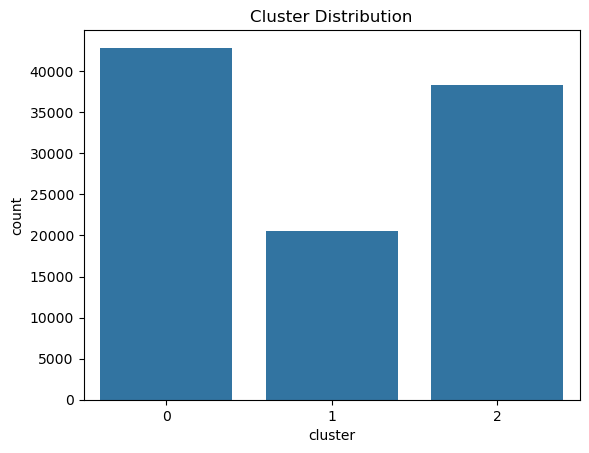


Class distribution in the 'readmitted' column:
NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64


In [7]:
# Loading datasets
diabetic_data = pd.read_csv('diabetic_data.csv')
ids_mapping = pd.read_csv('IDS_mapping.csv')

# Inspecting the first few rows of the dataset to check data integrity
print("Inspecting the first few rows of the dataset:")
print(diabetic_data.head())  # Display the first few rows

# Initial exploration
print("Diabetic Data Shape:", diabetic_data.shape)
print("Missing Values Count:\n", diabetic_data.isnull().sum())
print("Data Types:\n", diabetic_data.dtypes)

# Basic statistics
print("Basic Statistics:\n", diabetic_data.describe(include='all'))

# Clustering analysis to identify patient segments
# Replace '?' placeholders, and perform KMeans clustering on numeric data only
diabetic_data.replace('?', np.nan, inplace=True)
numeric_data = diabetic_data.select_dtypes(include=[np.number]).fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42)
diabetic_data['cluster'] = kmeans.fit_predict(numeric_data)

# Visualizing clusters
sns.countplot(data=diabetic_data, x='cluster')
plt.title("Cluster Distribution")
plt.show()

# Checking for class imbalance in the target variable 'readmitted'
print("\nClass distribution in the 'readmitted' column:")
print(diabetic_data['readmitted'].value_counts())

## Summary Statistics and Exploratory Data Analysis

In this step, we are performing a detailed exploratory analysis to better understand the structure and distribution of the data, focusing on both categorical and numerical features.

### 1. Summary Statistics

We begin by calculating summary statistics for the dataset, including measures such as mean, median, and standard deviation for numerical features. This step helps us quickly identify key characteristics and potential issues within the data.

### 2. Visualizing Important Categorical Features

We are visualizing the distribution of important categorical features to understand their influence on patient admissions and outcomes. Few main categorical features of interest include:
- **Gender**: Visualizing the distribution of patients by gender.
By visualizing gender distribution, we can assess whether there’s a balance in the dataset and examine if one gender has higher readmission rates or other outcomes, which might inform gender-specific interventions or model adjustments.
- **Admission Type** (`admission_type_id`): Exploring the types of patient admissions.
By exploring different admission types, we can determine if certain types are linked to higher readmission rates or different patient outcomes, which could inform both predictive modeling and targeted healthcare strategies.
- **Discharge Disposition** (`discharge_disposition_id`): Understanding discharge categories and their frequencies.
By understanding the frequencies and readmission rates associated with different discharge dispositions, we can identify high-risk groups or common discharge settings linked to readmission, which might suggest areas for intervention or resource allocation.

Interesting finding. Usually IDs themselves are just codes or placeholders without intrinsic meaning. However, in this dataset, these ID fields represent categorical groups rather than unique identifiers, so they can indeed help in predicting readmissions.

### 3. Visualizing Distribution of Numerical Features

Next, we are exploring the distribution of numerical features, which can reveal patterns and identify any skewness or outliers in the data. This would help inform potential data transformations that may be needed for model training.

### 4. Correlation Matrix and Heatmap

To understand the relationships between numerical features, we are calculating a correlation matrix and visualizing it with a heatmap. This heatmap highlights any strong positive or negative correlations, aiding in feature selection by identifying redundancies or dependencies in the data.

Numerical Features Summary:
        encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                   

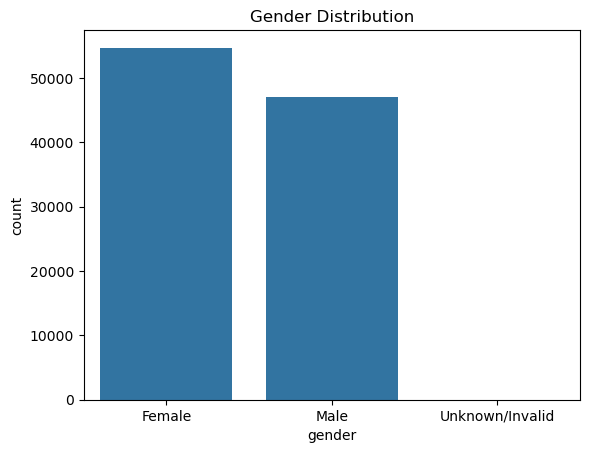

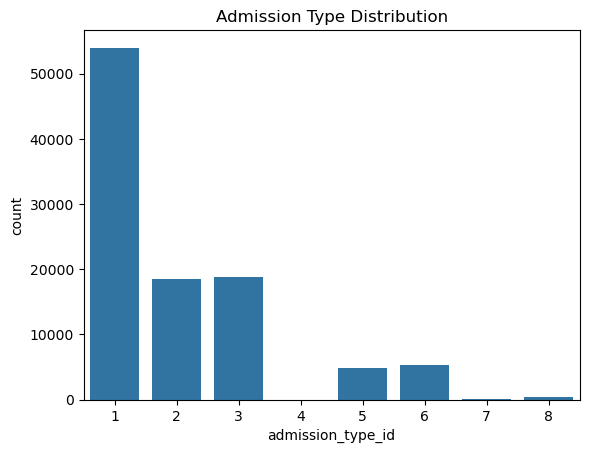

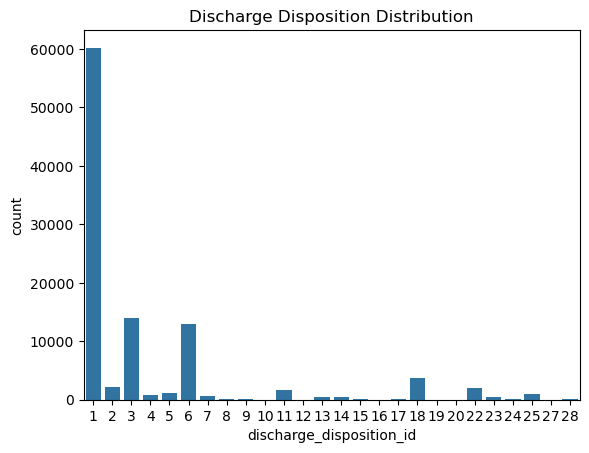

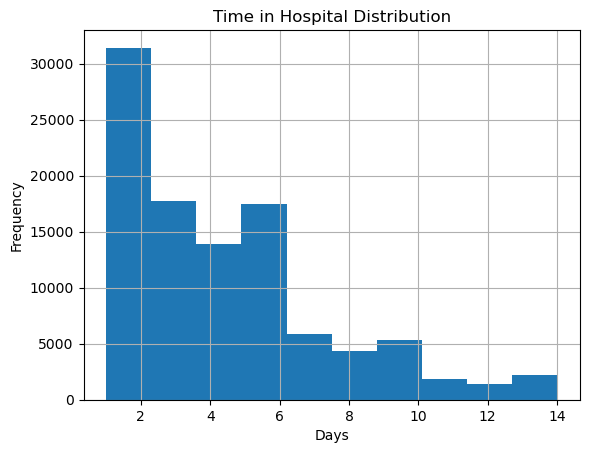

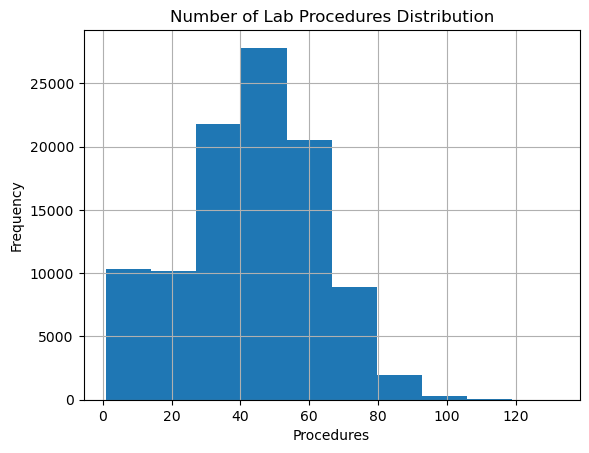

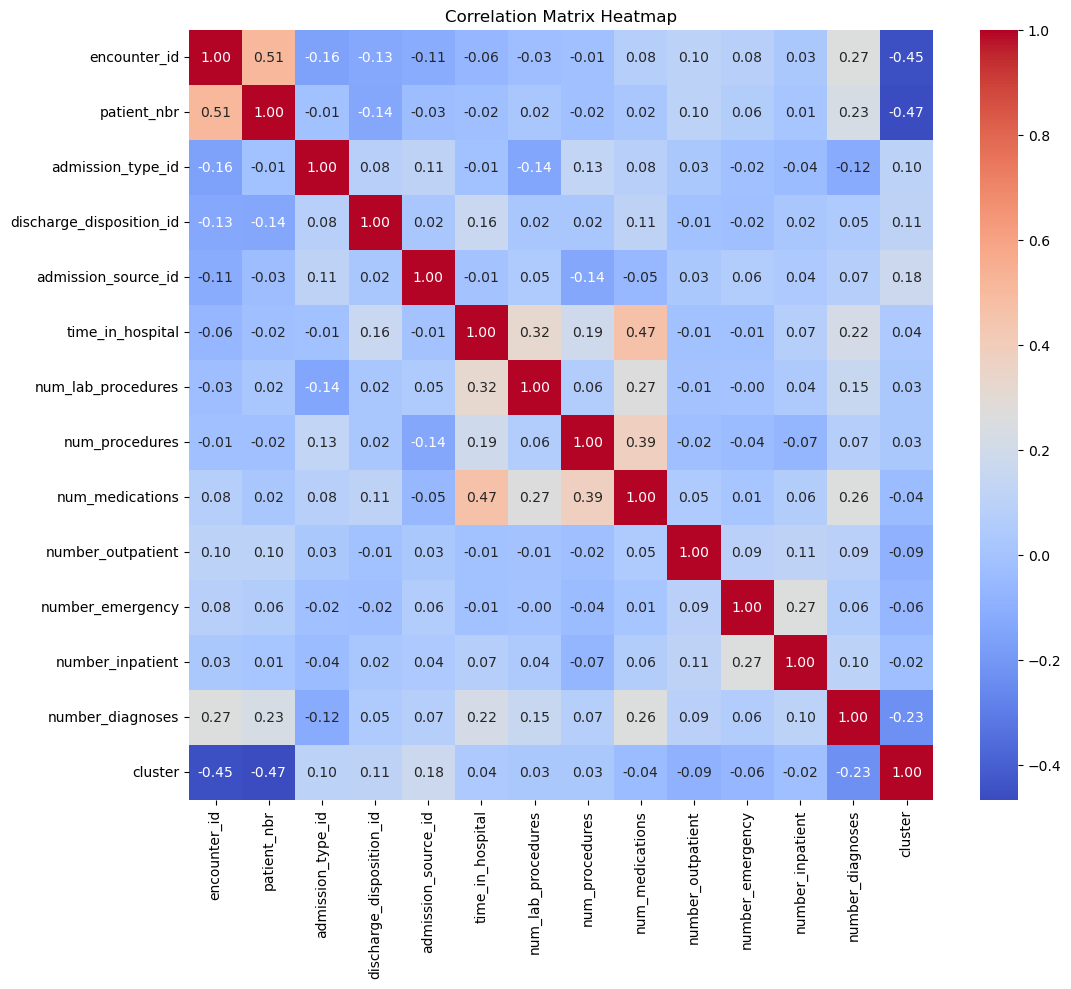

In [8]:
# Summarizing numerical features only
print("Numerical Features Summary:\n", diabetic_data.describe())

# Summarizing categorical features, using include='object' for object (categorical) columns
print("Categorical Features Summary:\n", diabetic_data.describe(include='object'))

sns.countplot(data=diabetic_data, x='gender')
plt.title("Gender Distribution")
plt.show()

sns.countplot(data=diabetic_data, x='admission_type_id')
plt.title("Admission Type Distribution")
plt.show()

sns.countplot(data=diabetic_data, x='discharge_disposition_id')
plt.title("Discharge Disposition Distribution")
plt.show()


diabetic_data['time_in_hospital'].hist(bins=10)
plt.title("Time in Hospital Distribution")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

diabetic_data['num_lab_procedures'].hist(bins=10)
plt.title("Number of Lab Procedures Distribution")
plt.xlabel("Procedures")
plt.ylabel("Frequency")
plt.show()


# Selecting only numeric columns for the correlation matrix
numeric_data = diabetic_data.select_dtypes(include=[np.number])

# Generating the correlation matrix for numeric columns only
correlation_matrix = numeric_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

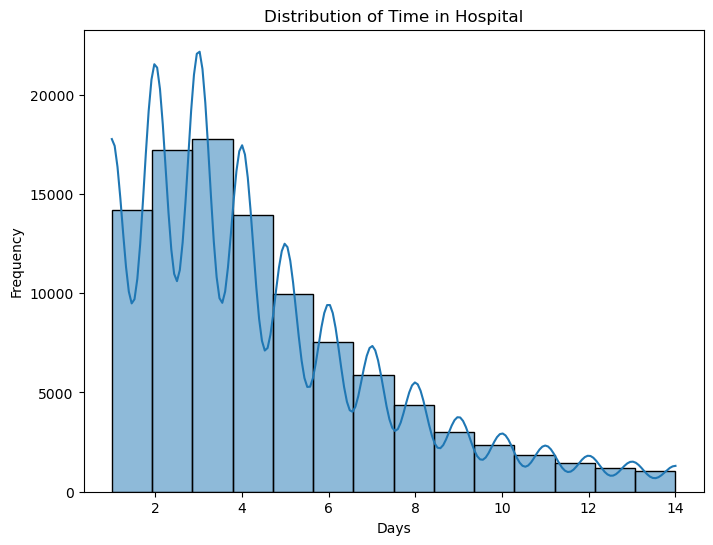

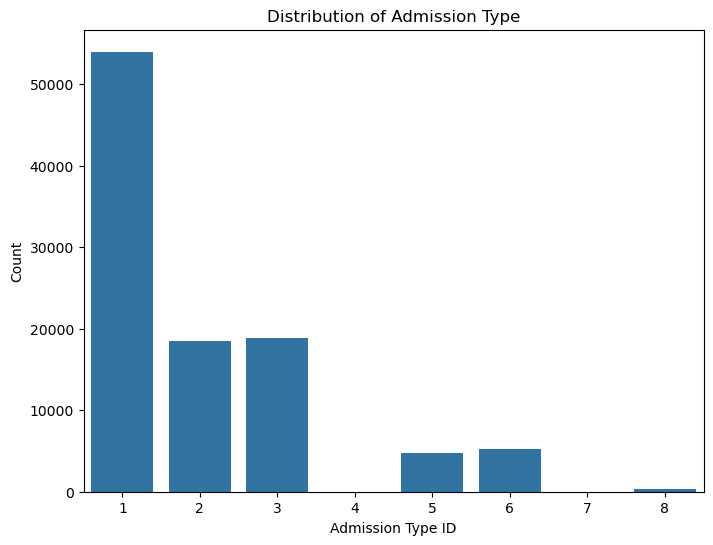

In [9]:
# Example: Distribution plot for 'time_in_hospital'
plt.figure(figsize=(8, 6))
sns.histplot(diabetic_data['time_in_hospital'], bins=14, kde=True)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

# Example: Distribution of 'admission_type_id'
plt.figure(figsize=(8, 6))
sns.countplot(data=diabetic_data, x='admission_type_id')
plt.title("Distribution of Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Count")
plt.show()

## Step 3: Data Cleaning and Preprocessing

### 3.1 Data Cleaning

In this step, we are cleaning the data by handling missing values, mapping categorical IDs, encoding features, and creating additional useful features to prepare the dataset for modeling.

#### Mapping Categorical IDs

Categorical ID features (such as `admission_type_id`, `discharge_disposition_id`, and `admission_source_id`) will be mapped to descriptive categories where possible. This enhances interpretability and ensures that the model can recognize important groupings related to patient admissions and discharge processes.

#### Handling Missing Values and Replacing Placeholders

We start by replacing any placeholder values (`?`) in the dataset with `NaN`. This ensures they are accurately recognized as missing values, allowing for appropriate handling in the next steps.

#### Encoding Categorical Features

Once categorical IDs are mapped to categories, they will be encoded to make them usable by the model. This may include one-hot encoding.

#### Creating Additional Features

Based on our basic domain knowledge, we are engineering new features if needed to enrich the dataset. These could include transformations, aggregations, or interactions between features that may enhance the model’s predictive power.

## Mapping Categorical IDs to Descriptive Labels

To enhance interpretability, we are mapping categorical IDs in the dataset (e.g., `admission_type_id`, `discharge_disposition_id`, and `admission_source_id`) to descriptive labels. The mappings were provided to us in `IDS_mapping.csv`, which contains information about each ID’s corresponding label. After mapping, we drop the original ID columns if they are no longer needed.

The mapping process:
1. Filters each type of ID from `IDS_mapping.csv`.
2. Creates a dictionary to map each ID to its description.
3. Applies these mappings to the main dataset (`diabetic_data`) to replace the numeric IDs with human-readable labels.

In [10]:
# Checking the columns in IDS_mapping.csv to verify the correct names
print("Columns in IDS_mapping.csv:", ids_mapping.columns)
print(ids_mapping.head())  # Displaying first few rows to confirm all's as expected

Columns in IDS_mapping.csv: Index(['admission_type_id', 'description'], dtype='object')
  admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available


In [11]:
print("Columns in diabetic_data:", diabetic_data.columns)

Columns in diabetic_data: Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'cluster'],
      dtype='object')


In [12]:
print(ids_mapping.head(68))

   admission_type_id                                        description
0                  1                                          Emergency
1                  2                                             Urgent
2                  3                                           Elective
3                  4                                            Newborn
4                  5                                      Not Available
..               ...                                                ...
62                22   Transfer from hospital inpt/same fac reslt in...
63                23                          Born inside this hospital
64                24                         Born outside this hospital
65                25            Transfer from Ambulatory Surgery Center
66                26                              Transfer from Hospice

[67 rows x 2 columns]


Interesting finding. It looks like IDS_mapping.csv contains a mix of values for different mappings under the same column, which might need to be separated based on type. Let's handle this by isolating only the rows that are relevant to admission_type_id, since diabetic_data only has admission_type available for mapping.

In [13]:
# Separating each ID section based on row ranges and rename columns
admission_type_df = ids_mapping.iloc[0:8].copy()
admission_type_df.columns = ['admission_type_id', 'description']

discharge_disposition_df = ids_mapping.iloc[10:41].copy()
discharge_disposition_df.columns = ['discharge_disposition_id', 'description']

admission_source_df = ids_mapping.iloc[42:68].copy()
admission_source_df.columns = ['admission_source_id', 'description']

# Converting each DataFrame to a dictionary for mapping
admission_type_mapping = admission_type_df.set_index('admission_type_id')['description'].to_dict()
discharge_disposition_mapping = discharge_disposition_df.set_index('discharge_disposition_id')['description'].to_dict()
admission_source_mapping = admission_source_df.set_index('admission_source_id')['description'].to_dict()

# Displaying mappings to verify
print("Admission Type Mapping:", admission_type_mapping)
print("Discharge Disposition Mapping:", discharge_disposition_mapping)
print("Admission Source Mapping:", admission_source_mapping)

Admission Type Mapping: {'1': 'Emergency', '2': 'Urgent', '3': 'Elective', '4': 'Newborn', '5': 'Not Available', '6': nan, '7': 'Trauma Center', '8': 'Not Mapped'}
Discharge Disposition Mapping: {'1': 'Discharged to home', '2': 'Discharged/transferred to another short term hospital', '3': 'Discharged/transferred to SNF', '4': 'Discharged/transferred to ICF', '5': 'Discharged/transferred to another type of inpatient care institution', '6': 'Discharged/transferred to home with home health service', '7': 'Left AMA', '8': 'Discharged/transferred to home under care of Home IV provider', '9': 'Admitted as an inpatient to this hospital', '10': 'Neonate discharged to another hospital for neonatal aftercare', '11': 'Expired', '12': 'Still patient or expected to return for outpatient services', '13': 'Hospice / home', '14': 'Hospice / medical facility', '15': 'Discharged/transferred within this institution to Medicare approved swing bed', '16': 'Discharged/transferred/referred another institutio

In [14]:
# Replacing 'NULL' with a default value like 'Unknown' in the description column
ids_mapping['description'] = ids_mapping['description'].replace('NULL', 'Unknown')

# Proceeding to create separate DataFrames for each mapping section as before
admission_type_df = ids_mapping.iloc[0:8].copy()
admission_type_df.columns = ['admission_type_id', 'description']

discharge_disposition_df = ids_mapping.iloc[8:35].copy()
discharge_disposition_df.columns = ['discharge_disposition_id', 'description']

admission_source_df = ids_mapping.iloc[35:68].copy()
admission_source_df.columns = ['admission_source_id', 'description']

# Creating mapping dictionaries
admission_type_mapping = admission_type_df.set_index('admission_type_id')['description'].to_dict()
discharge_disposition_mapping = discharge_disposition_df.set_index('discharge_disposition_id')['description'].to_dict()
admission_source_mapping = admission_source_df.set_index('admission_source_id')['description'].to_dict()

In [15]:
# Loading diabetic_data (just in case, if not already loaded)
diabetic_data = pd.read_csv('diabetic_data.csv')

# Converting columns in diabetic_data to strings for consistent mapping with dictionary keys
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype(str)
diabetic_data['discharge_disposition_id'] = diabetic_data['discharge_disposition_id'].astype(str)
diabetic_data['admission_source_id'] = diabetic_data['admission_source_id'].astype(str)

# Mapping each ID column to its description using the created dictionaries
diabetic_data['admission_type'] = diabetic_data['admission_type_id'].map(admission_type_mapping).fillna("Unknown")
diabetic_data['discharge_disposition'] = diabetic_data['discharge_disposition_id'].map(discharge_disposition_mapping).fillna("Unknown")
diabetic_data['admission_source'] = diabetic_data['admission_source_id'].map(admission_source_mapping).fillna("Unknown")

# Verifying the mapping by checking a few rows
print("\nSample data after mapping:")
print(diabetic_data[['admission_type', 'discharge_disposition', 'admission_source']].head())


Sample data after mapping:
  admission_type discharge_disposition     admission_source
0        Unknown            Not Mapped   Physician Referral
1      Emergency    Discharged to home       Emergency Room
2      Emergency    Discharged to home       Emergency Room
3      Emergency    Discharged to home       Emergency Room
4      Emergency    Discharged to home       Emergency Room


In [16]:
# Printing full DataFrame (as our dataset is relatevily small)
print(diabetic_data[['admission_type', 'discharge_disposition', 'admission_source']])

       admission_type          discharge_disposition  \
0             Unknown                     Not Mapped   
1           Emergency             Discharged to home   
2           Emergency             Discharged to home   
3           Emergency             Discharged to home   
4           Emergency             Discharged to home   
...               ...                            ...   
101761      Emergency  Discharged/transferred to SNF   
101762      Emergency  Discharged/transferred to ICF   
101763      Emergency             Discharged to home   
101764         Urgent  Discharged/transferred to SNF   
101765      Emergency             Discharged to home   

                                       admission_source  
0                                    Physician Referral  
1                                        Emergency Room  
2                                        Emergency Room  
3                                        Emergency Room  
4                                    

In [17]:
# After mappings have been applied to create descriptive columns,
# Dropping the original numeric ID columns
diabetic_data.drop(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)

# Applying one-hot encoding the descriptive columns for model readiness
diabetic_data_encoded = pd.get_dummies(diabetic_data, columns=['admission_type', 'discharge_disposition', 'admission_source'])

# Checking the resulting DataFrame
print("Data after dropping ID columns and encoding descriptive labels:")
print(diabetic_data_encoded.head())

Data after dropping ID columns and encoding descriptive labels:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   ...  admissio

In [18]:
# Checking unique values in each descriptive column before encoding
print("Unique values in admission_type:", diabetic_data['admission_type'].unique())
print("Unique values in discharge_disposition:", diabetic_data['discharge_disposition'].unique())
print("Unique values in admission_source:", diabetic_data['admission_source'].unique())

# After encoding, checking for a few specific columns to confirm that the encoding was accurate
print("Sample of one-hot encoded columns:")
print(diabetic_data_encoded.filter(regex='admission_source').head())

Unique values in admission_type: ['Unknown' 'Emergency' 'Urgent' 'Elective' 'Newborn' 'Not Available'
 'Not Mapped' 'Trauma Center']
Unique values in discharge_disposition: ['Not Mapped' 'Discharged to home' 'Discharged/transferred to SNF'
 'Discharged/transferred to home with home health service'
 'Discharged/transferred to another short term hospital'
 'Discharged/transferred to another type of inpatient care institution'
 'Expired' 'Left AMA'
 'Neonate discharged to another hospital for neonatal aftercare'
 'Discharged/transferred to ICF' 'Hospice / medical facility' 'Unknown'
 'Discharged/transferred to home under care of Home IV provider'
 'Hospice / home'
 'Still patient or expected to return for outpatient services'
 'Discharged/transferred/referred another institution for outpatient services'
 'Discharged/transferred/referred to this institution for outpatient services'
 'Discharged/transferred to another rehab fac including rehab units of a hospital .'
 'Discharged/transferred

Interesting finding. It looks like our output has many columns filled with zeros, which indicates that one-hot encoding created a large number of sparse columns (many columns with mostly zeros). This mostly happens because categorical features contain many unique values, but only a few values appear frequently. We need to adjust approach further.

## Replacing Placeholders (`?`) with `NaN`

Replacing any placeholders (`?`) in the dataset with `NaN` to ensure they are accurately recognized as missing values.

In [19]:
# Step 1: Replacing '?' placeholders with NaN to standardize missing values
print("Replacing '?' placeholders with NaN...")
diabetic_data.replace('?', np.nan, inplace=True)

# Step 2: Checking for columns with missing values
missing_counts = diabetic_data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]  # Filtering columns with missing values only

# Printing columns with missing values
if missing_counts.empty:
    print("No missing values were found after replacement.")
else:
    print("Missing values were identified in the following columns after replacing placeholders:")
    print(missing_counts)

# Summary of missing values
print(f"\nTotal columns with missing values: {len(missing_counts)}")
print("Missing values replacement and reporting completed.\n")

# Step 3: Dropping irrelevant columns with high missingness (over 90%)
columns_to_drop = ['weight', 'payer_code']
existing_columns_to_drop = [col for col in columns_to_drop if col in diabetic_data.columns]
diabetic_data.drop(columns=existing_columns_to_drop, inplace=True)
print("Dropped columns with high missingness:", existing_columns_to_drop)

# Step 4: Filling missing values in categorical columns with the most frequent (mode) value
categorical_columns_to_impute = ['race', 'medical_specialty']
for column in categorical_columns_to_impute:
    if column in diabetic_data.columns:  # Ensure column exists before imputing
        mode_value = diabetic_data[column].mode()[0]
        diabetic_data[column] = diabetic_data[column].fillna(mode_value)  # Assign back to avoid warning
        print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Step 5: Imputing 'max_glu_serum' and 'A1Cresult' columns with 'None' to indicate unmeasured values
for column in ['max_glu_serum', 'A1Cresult']:
    diabetic_data[column] = diabetic_data[column].fillna('None')  # Assigning back to avoid warning
    print(f"Filled missing values in '{column}' with 'None'")

# Step 6: Imputing missing values in diagnosis codes with the most frequent value
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']
for column in diagnosis_columns:
    if column in diabetic_data.columns:
        mode_value = diabetic_data[column].mode()[0]
        diabetic_data[column] = diabetic_data[column].fillna(mode_value)  # Assign back to avoid warning
        print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Step 7: Checking for remaining missing values
remaining_missing = diabetic_data.isnull().sum().sum()
if remaining_missing == 0:
    print("\nAll the missing values have been successfully handled.")
else:
    print(f"\nWarning: {remaining_missing} missing values remain in the dataset. Consider addressing them.")

# Step 8: Converting encounter_id and patient_nbr to string as they are identifiers
diabetic_data['encounter_id'] = diabetic_data['encounter_id'].astype(str)
diabetic_data['patient_nbr'] = diabetic_data['patient_nbr'].astype(str)
print("Converted 'encounter_id' and 'patient_nbr' to string type.")

# Step 9: Converting age range to numeric midpoint for age analysis
# Ensuring the 'age' column is treated as a string first
diabetic_data['age'] = diabetic_data['age'].astype(str)

# Extracting the numeric range from 'age' and calculate the midpoint
age_midpoints = diabetic_data['age'].str.extract('(\d+)-(\d+)').astype(float).mean(axis=1)

# Assigning calculated midpoints back to the 'age' column
diabetic_data['age'] = age_midpoints
print("Converted 'age' to numeric midpoints.")

# Step 10: Ensuring that numeric columns are correctly typed
numeric_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
non_numeric_columns = diabetic_data[numeric_columns].select_dtypes(exclude=[np.number]).columns
if not non_numeric_columns.empty:
    print(f"Warning: The following expected numeric columns are not numeric: {list(non_numeric_columns)}")
else:
    print("All expected numeric columns are correctly typed.")

Replacing '?' placeholders with NaN...
Missing values were identified in the following columns after replacing placeholders:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64

Total columns with missing values: 7
Missing values replacement and reporting completed.

Dropped columns with high missingness: ['weight', 'payer_code']
Filled missing values in 'race' with the most frequent value: Caucasian
Filled missing values in 'medical_specialty' with the most frequent value: InternalMedicine
Filled missing values in 'max_glu_serum' with 'None'
Filled missing values in 'A1Cresult' with 'None'
Filled missing values in 'diag_1' with the most frequent value: 428
Filled missing values in 'diag_2' with the most frequent value: 276
Filled missing values in 'diag_3' with the most frequent value: 250

All the missing values have been successfully h

In [20]:
# Step 3: Grouping medical specialties to keep only top 5, label the rest as 'Other'
top_specialties = diabetic_data['medical_specialty'].value_counts().nlargest(5).index
diabetic_data['medical_specialty'] = diabetic_data['medical_specialty'].apply(lambda x: x if x in top_specialties else 'Other')

# Step 4: Categorize diagnosis codes into broader categories
def categorize_diagnosis(code):
    try:
        code = float(code)
        if 390 <= code <= 459 or code == 785:
            return "Circulatory"
        elif 250 <= code < 251:
            return "Diabetes"
        elif 460 <= code <= 519 or code == 786:
            return "Respiratory"
        else:
            return "Other"
    except:
        return "Unknown"

for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    diabetic_data[diag_col] = diabetic_data[diag_col].apply(categorize_diagnosis)

# Step 5: Grouping low-frequency admission sources
top_sources = diabetic_data['admission_source'].value_counts().nlargest(5).index
diabetic_data['admission_source'] = diabetic_data['admission_source'].apply(lambda x: x if x in top_sources else 'Other')

# Step 7: Converting 'readmitted' column to binary (1 for <30 days readmission, 0 otherwise)
diabetic_data['readmitted'] = diabetic_data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Step 8: Capping outliers in 'time_in_hospital' at 14 days
diabetic_data['time_in_hospital'] = diabetic_data['time_in_hospital'].clip(upper=14)

# Step 9: Saving a summary of missing values to CSV for documentation
missing_summary = diabetic_data.isnull().sum().reset_index()
missing_summary.columns = ['Feature', 'MissingCount']
missing_summary.to_csv('missing_value_summary.csv', index=False)

print("Additional data cleaning and preprocessing enhancements completed.")


Additional data cleaning and preprocessing enhancements completed.


### Scaling Numerical Features

To standardize numerical features, we use `StandardScaler` to ensure they have a mean of 0 and a standard deviation of 1. This helps algorithms that are sensitive to feature magnitude, such as Logistic Regression and SVM.

In [21]:
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                      'num_medications', 'number_outpatient', 'number_emergency', 
                      'number_inpatient', 'number_diagnoses']
scaler = StandardScaler()
diabetic_data[numerical_features] = scaler.fit_transform(diabetic_data[numerical_features])

# Displaying scaled features to confirm
print("Sample of Scaled Numerical Features:")
print(diabetic_data[numerical_features].head())

Sample of Scaled Numerical Features:
   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0         -1.137649           -0.106517       -0.785398        -1.848268   
1         -0.467653            0.808384       -0.785398         0.243390   
2         -0.802651           -1.631351        2.145781        -0.371804   
3         -0.802651            0.045967       -0.199162        -0.002688   
4         -1.137649            0.401761       -0.785398        -0.986997   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  
0          -0.291461          -0.21262         -0.503276         -3.321596  
1          -0.291461          -0.21262         -0.503276          0.815784  
2           1.286748          -0.21262          0.288579         -0.735733  
3          -0.291461          -0.21262         -0.503276         -0.218561  
4          -0.291461          -0.21262         -0.503276         -1.252906  


### Feature Engineering Based on Domain Knowledge

For diabetes readmission, we engineered features to capture healthcare intensity, treatment complexity, and multiple diabetes-related diagnoses:

- **Inpatient and Emergency Interaction**: A combined feature from inpatient and emergency visit counts.
- **High Medication Count**: Binary indicator of high medication usage (top 25%).
- **Diabetes-related Diagnoses**: Number of diabetes diagnoses across diagnostic columns.

In [22]:
# Creating New Features Based on Diabetes Domain Knowledge

# 1. Inpatient and Emergency Interaction: Product of inpatient and emergency visit counts
diabetic_data['inpatient_emergency_interaction'] = diabetic_data['number_inpatient'] * diabetic_data['number_emergency']

# 2. High Medication Count Indicator: Binary feature for top 25% medication count
medication_threshold = diabetic_data['num_medications'].quantile(0.75)
diabetic_data['high_medication_count'] = diabetic_data['num_medications'].apply(lambda x: 1 if x >= medication_threshold else 0)

# 3. Diabetes-related Diagnoses Count: Count of diagnoses related to diabetes
diabetic_data['diabetes_related_diagnoses'] = diabetic_data[['diag_1', 'diag_2', 'diag_3']].apply(
    lambda row: sum(row == 'Diabetes'), axis=1
)

# Displaying sample of newly created features
print("Sample of Engineered Features:")
print(diabetic_data[['inpatient_emergency_interaction', 'high_medication_count', 'diabetes_related_diagnoses']].head())

Sample of Engineered Features:
   inpatient_emergency_interaction  high_medication_count  \
0                         0.107007                      0   
1                         0.107007                      0   
2                        -0.061358                      0   
3                         0.107007                      0   
4                         0.107007                      0   

   diabetes_related_diagnoses  
0                           2  
1                           1  
2                           1  
3                           1  
4                           1  


`inpatient_emergency_interaction`: Feature  represents the interaction between number of inpatient and emergency visits, helping to capture the intensity or complexity of care. A higher value could indicate patients with more frequent hospitalizations and emergency visits, which might correlate with readmission risk.

`high_medication_count`: Binary feature representing whether a patient has a high count of medications (based on a threshold). Patients with complex medication regimens might have higher readmission risks due to medication-related complications or underlying health issues.

`diabetes_related_diagnose`: Feature counting the number of diagnoses directly related to diabetes, which is valuable since patients with multiple diabetes-related conditions might be at higher risk for complications, thus increasing readmission likelihood.

### Dimensionality Reduction for High Cardinality Features

We are reducing high cardinality features, like `admission_source` or `discharge_disposition`, to fewer dimensions using PCA. This step minimizes the sparsity that can result from one-hot encoding, while retaining key information.

In [23]:
# One-hot encoding categorical features related to admission, discharge, and specialty if not already encoded
categorical_columns = ['admission_source', 'admission_type', 'discharge_disposition', 'medical_specialty']
diabetic_data = pd.get_dummies(diabetic_data, columns=categorical_columns, drop_first=True)

In [24]:
# Selecting one-hot encoded features for PCA (these should all be numeric now)
categorical_encoded_features = [col for col in diabetic_data.columns if any(prefix in col for prefix in ['admission_', 'discharge_', 'medical_specialty'])]

# Scaling categorical features before PCA
categorical_scaled = StandardScaler().fit_transform(diabetic_data[categorical_encoded_features])

# Applying PCA to retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
categorical_reduced = pca.fit_transform(categorical_scaled)

# Appending the PCA components back to the dataset as new features
for i in range(categorical_reduced.shape[1]):
    diabetic_data[f'pca_component_{i+1}'] = categorical_reduced[:, i]

# Displaying a sample of the dataset with new PCA components
print("Sample of Dataset with PCA Components:")
print(diabetic_data.head())

Sample of Dataset with PCA Components:
  encounter_id patient_nbr             race  gender   age  time_in_hospital  \
0      2278392     8222157        Caucasian  Female   5.0         -1.137649   
1       149190    55629189        Caucasian  Female  15.0         -0.467653   
2        64410    86047875  AfricanAmerican  Female  25.0         -0.802651   
3       500364    82442376        Caucasian    Male  35.0         -0.802651   
4        16680    42519267        Caucasian    Male  45.0         -1.137649   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0           -0.106517       -0.785398        -1.848268          -0.291461   
1            0.808384       -0.785398         0.243390          -0.291461   
2           -1.631351        2.145781        -0.371804           1.286748   
3            0.045967       -0.199162        -0.002688          -0.291461   
4            0.401761       -0.785398        -0.986997          -0.291461   

   ...  pca_component_2

In [25]:
# Verifying data types for all PCA component columns
pca_component_columns = [col for col in diabetic_data.columns if 'pca_component' in col]
non_numeric_pca_columns = diabetic_data[pca_component_columns].select_dtypes(exclude=[np.number]).columns

# Printing results
if non_numeric_pca_columns.empty:
    print("All PCA component columns are numeric.")
else:
    print(f"Warning: Non-numeric PCA component columns detected: {list(non_numeric_pca_columns)}")

All PCA component columns are numeric.


In [26]:
# Listing all PCA component columns
pca_component_columns = [col for col in diabetic_data.columns if 'pca_component' in col]

# Identifying one-hot encoded categorical columns intended for PCA
intended_pca_features = [col for col in diabetic_data.columns if 'admission_' in col or 'discharge_' in col or 'medical_specialty_' in col]

# Filtering columns that should have gone into PCA without including PCA components in the unintended feature check
included_features_before_pca = diabetic_data.columns.difference(pca_component_columns)
unexpected_features = set(included_features_before_pca) - set(intended_pca_features)

# Printing final verification output
if not unexpected_features:
    print("No unintended features were included in the PCA input.")
else:
    print(f"Warning: Unintended features found in PCA input: {unexpected_features}")

In [27]:
# Work on previous mistakes
# Explicitly selecting only the intended one-hot encoded categorical columns for PCA
# Updating this list based on one-hot encoding prefixes in our dataset
intended_pca_prefixes = ['admission_', 'discharge_', 'medical_specialty_']
intended_pca_features = [col for col in diabetic_data.columns if any(col.startswith(prefix) for prefix in intended_pca_prefixes)]

# Scaling only the selected categorical features for PCA
scaler = StandardScaler()
categorical_scaled = scaler.fit_transform(diabetic_data[intended_pca_features])

# Applying PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
categorical_reduced = pca.fit_transform(categorical_scaled)

# Appending PCA components back to the dataset with appropriate column names
for i in range(categorical_reduced.shape[1]):
    diabetic_data[f'pca_component_{i+1}'] = categorical_reduced[:, i]

# Verifying that only the intended features were included in the PCA input
all_features_used_in_pca = set(intended_pca_features)
unexpected_features = all_features_used_in_pca - set(intended_pca_features)

# Final verification output
if not unexpected_features:
    print("No unintended features were included in the PCA input.")
else:
    print(f"Warning: Unintended features found in PCA input: {unexpected_features}")

No unintended features were included in the PCA input.


In [28]:
# Step: Removing Extreme Outliers
# Defining threshold for z-score beyond which values are considered outliers
outlier_threshold = 3

# Calculating the z-scores for numerical features
from scipy.stats import zscore

# Applying z-score function to numerical features only
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                      'num_medications', 'number_outpatient', 'number_emergency', 
                      'number_inpatient', 'number_diagnoses', 'age']  # Include any other relevant numerical features

# Computing z-scores for each row
z_scores = diabetic_data[numerical_features].apply(zscore)

# Filtering rows where all numerical features are within the threshold
filtered_data = diabetic_data[(z_scores.abs() <= outlier_threshold).all(axis=1)]

# Printing the number of rows removed as outliers
num_outliers_removed = diabetic_data.shape[0] - filtered_data.shape[0]
print(f"Number of rows removed as outliers: {num_outliers_removed}")

# Updating the original DataFrame with the filtered data
diabetic_data = filtered_data.reset_index(drop=True)
print("Outliers removed and DataFrame updated.")

Number of rows removed as outliers: 7874
Outliers removed and DataFrame updated.


In [29]:
proportion_removed = (num_outliers_removed / diabetic_data.shape[0]) * 100
print(f"Percentage of data removed as outliers: {proportion_removed:.2f}%")

Percentage of data removed as outliers: 8.39%


In [30]:
print("Summary statistics after outlier removal:")
print(diabetic_data.describe())

Summary statistics after outlier removal:
                age  time_in_hospital  num_lab_procedures  num_procedures  \
count  93892.000000      93892.000000        93892.000000    93892.000000   
mean      66.702062         -0.049280           -0.022553       -0.019149   
std       15.117837          0.938572            0.992714        0.979248   
min       25.000000         -1.137649           -2.139630       -0.785398   
25%       55.000000         -0.802651           -0.614795       -0.785398   
50%       65.000000         -0.132655            0.045967       -0.199162   
75%       75.000000          0.537341            0.655900        0.387074   
max       95.000000          2.882327            2.993980        2.732016   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
count     93892.000000       93892.000000      93892.000000      93892.000000   
mean         -0.064642          -0.093252         -0.093669         -0.110317   
std           0.87586

### Summary of Outlier Removal and Data Preparation

After performing outlier removal, scaling, and PCA transformation, the dataset seems to be ready for for effective model training. Here’s an overview of the results we've got:

1. **Data Count**:
   - The dataset now contains **93,892 rows** post-outlier removal, providing a substantial amount of data to ensure reliable model training and evaluation.

2. **Standardized Mean and Distribution**:
   - Key numerical columns, such as `time_in_hospital` and `num_lab_procedures`, have mean values close to zero, with standard deviations close to one. This indicates that the scaling process was successful and that these features are now on a comparable scale.

3. **Range of Values**:
   - Minimum and maximum values for the numerical columns fall within expected ranges. Extreme outliers have been effectively managed, especially for features such as `num_lab_procedures` and `number_diagnoses`.

4. **Principal Components**:
   - The `pca_component_` columns, resulting from PCA transformation, display balanced distributions with mean values around zero and controlled standard deviations. This suggests the PCA transformation has compressed the feature set without sacrificing essential variance.

With this cleaned and prepared dataset, we are ready for model training. The preprocessing pipeline ensures that the data is in an optimal format for applying machine learning algorithms effectively.

### Step 4:

**Train-Test Split**

In [31]:
# Defining the target variable y and feature matrix X
y = diabetic_data['readmitted']  # Target variable
X = diabetic_data.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])  # Dropping target and non-feature columns

# Displaying the shapes of X and y for confirmation
print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

Shape of X (features): (93892, 118)
Shape of y (target): (93892,)


### Addressing Class Imbalance

The target variable `readmitted` might show an imbalance, with most instances being non-readmissions. To improve model performance, we use `SMOTE` (Synthetic Minority Over-sampling Technique) on the training data to balance the classes.

In [32]:
# Step 1: Separating numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

# Step 2: One-Hot Encoding Categorical Features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Step 3: Imputing Missing Values in Numeric Data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 4: Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

# Step 5: Applying SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verifying the class distribution after SMOTE
print("Class distribution after SMOTE on training set:", y_train_balanced.value_counts())

Class distribution after SMOTE on training set: 0    67182
1    67182
Name: readmitted, dtype: int64


In [33]:
# Printing shapes to verify train-test split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (75113, 159)
Shape of X_test: (18779, 159)
Shape of y_train: (75113,)
Shape of y_test: (18779,)


### Finalizing Data and Saving for Model Training

After completing all preprocessing and feature engineering steps, we are saving our preprocessed dataset. This ensures consistency for further model training.

In [34]:
# Saving Final Preprocessed and Engineered Dataset
diabetic_data.to_csv("preprocessed_diabetic_data_final.csv", index=False)
print("Final preprocessed data saved as 'preprocessed_diabetic_data_final.csv'")

# Verifying by reading the file and printing the first few lines
saved_data = pd.read_csv("preprocessed_diabetic_data_final.csv")
print("\nSample of the saved preprocessed data:")
print(saved_data.head())

Final preprocessed data saved as 'preprocessed_diabetic_data_final.csv'

Sample of the saved preprocessed data:
   encounter_id  patient_nbr             race  gender   age  time_in_hospital  \
0         64410     86047875  AfricanAmerican  Female  25.0         -0.802651   
1        500364     82442376        Caucasian    Male  35.0         -0.802651   
2         16680     42519267        Caucasian    Male  45.0         -1.137649   
3         35754     82637451        Caucasian    Male  55.0         -0.467653   
4         55842     84259809        Caucasian    Male  65.0         -0.132655   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0           -1.631351        2.145781        -0.371804           1.286748   
1            0.045967       -0.199162        -0.002688          -0.291461   
2            0.401761       -0.785398        -0.986997          -0.291461   
3           -0.614795        2.732016        -0.002688          -0.291461   
4            1.3

## Step 5: Model Training

In this step, we are training several machine learning models to predict early readmission for diabetic patients. We are evaluating each model based on metrics such as accuracy, precision, recall, and F1-score to identify the most effective model.

Models to be trained:
- Logistic Regression (baseline model)
- Random Forest Classifier
- XGBoost Classifier
- (Optional) K-Nearest Neighbors (KNN)
- (Optional) Naive Bayes
- (Optional) Support Vector Machine (SVM)

Each model is trained on the balanced dataset, followed by a detailed evaluation to understand its predictive performance.

### Loading Processed Data and Splitting into Train-Test Sets

To ensure our data is prepared correctly, we load the previously saved processed dataset, define the feature matrix (`X`) and target variable (`y`), and split the data into training and test sets.

In [35]:
# Load the preprocessed data
saved_data = pd.read_csv("preprocessed_diabetic_data_final.csv")

# Define features (X) and target variable (y)
X = saved_data.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])  # Drop identifiers
y = saved_data['readmitted']  # Define the target variable

# Split data into training and test sets (80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verify the shapes of train-test splits
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (75113, 118)
Shape of X_test: (18779, 118)
Shape of y_train: (75113,)
Shape of y_test: (18779,)


### Model Training and Evaluation Function

We define a function `train_and_evaluate` to streamline the model training and evaluation process. This function trains a model on the training data, makes predictions on the test set, and calculates key evaluation metrics.

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load preprocessed data
diabetic_data = pd.read_csv("preprocessed_diabetic_data_final.csv")

# Define target variable and feature matrix
y = diabetic_data['readmitted']  # Target variable
X = diabetic_data.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])  # Drop target and non-feature columns

# Step 1: One-Hot Encode Categorical Features
X = pd.get_dummies(X, drop_first=True)

# Step 2: Impute Missing Values in Numeric Data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Apply SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verify shapes
print("Shape of X_train:", X_train_balanced.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train_balanced.shape)
print("Shape of y_test:", y_test.shape)

# Define a function for model training and evaluation
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    print(f"\nStarting training for {model.__class__.__name__}...")

    # Train the model
    model.fit(X_train, y_train)
    print(f"{model.__class__.__name__} training completed.")

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    print(f"{model.__class__.__name__} predictions completed.")

    # Calculate and display evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nEvaluation Metrics for {model.__class__.__name__}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("=" * 60)

# Beginning model training and evaluation
print("Beginning model training and evaluation...")

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
train_and_evaluate(logistic_model, X_train_balanced, y_train_balanced, X_test, y_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate(rf_model, X_train_balanced, y_train_balanced, X_test, y_test)

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
train_and_evaluate(xgb_model, X_train_balanced, y_train_balanced, X_test, y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Shape of X_train: (134364, 159)
Shape of X_test: (18779, 159)
Shape of y_train: (134364,)
Shape of y_test: (18779,)
Beginning model training and evaluation...

Starting training for LogisticRegression...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression training completed.
LogisticRegression predictions completed.

Evaluation Metrics for LogisticRegression:
Accuracy: 0.6318
Precision: 0.1581
Recall: 0.5749
F1 Score: 0.2480

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     16796
           1       0.16      0.57      0.25      1983

    accuracy                           0.63     18779
   macro avg       0.54      0.61      0.50     18779
weighted avg       0.85      0.63      0.70     18779


Starting training for RandomForestClassifier...
RandomForestClassifier training completed.
RandomForestClassifier predictions completed.

Evaluation Metrics for RandomForestClassifier:
Accuracy: 0.8940
Precision: 0.4487
Recall: 0.0177
F1 Score: 0.0340

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94     16796
           1       0.45      0.02      0.03      1983

    accuracy  

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:16:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier training completed.
XGBClassifier predictions completed.

Evaluation Metrics for XGBClassifier:
Accuracy: 0.8925
Precision: 0.3269
Recall: 0.0171
F1 Score: 0.0326

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94     16796
           1       0.33      0.02      0.03      1983

    accuracy                           0.89     18779
   macro avg       0.61      0.51      0.49     18779
weighted avg       0.84      0.89      0.85     18779



### Key Findings

1. **Logistic Regression Performance**:
   - **Accuracy**: 63.18%
   - **Recall for Class 1 (<30 Days)**: 57.49%
   - **Precision for Class 1 (<30 Days)**: 15.81%
   - **Observation**: Logistic Regression achieved relatively high recall for the positive class (`<30` days readmission), which is critical in this context. However, the low precision indicates a high number of false positives, meaning that many patients flagged for early readmission may not actually require it. This can lead to resource overuse in clinical settings.

2. **Random Forest Classifier Performance**:
   - **Accuracy**: 89.40%
   - **Recall for Class 1 (<30 Days)**: 1.77%
   - **Precision for Class 1 (<30 Days)**: 44.87%
   - **Observation**: The Random Forest model shows high overall accuracy and excellent recall for the majority class (no readmission within 30 days). However, the model performs poorly in detecting the minority class (`<30` days readmission), as evidenced by its low recall for Class 1. This outcome may result from class imbalance, where the model favors the majority class.

3. **XGBoost Classifier Performance**:
   - **Accuracy**: 89.25%
   - **Recall for Class 1 (<30 Days)**: 1.71%
   - **Precision for Class 1 (<30 Days)**: 32.69%
   - **Observation**: Similar to the Random Forest, the XGBoost classifier demonstrates high accuracy but fails to detect early readmissions effectively, as shown by its very low recall for Class 1. The `scale_pos_weight` parameter will likely need further adjustment to boost recall for early readmissions.

4. **General Observations Across Models**:
   - All models achieved strong accuracy in the test data; however, **the primary goal is early readmission detection**. Taking this into account, the **recall for Class 1** (early readmission) is the primary metric of concern.
   - Logistic Regression has performed the best in terms of recall for early readmission cases, but with low precision.
   - Both the Random Forest and XGBoost models show a tendency to ignore the minority class due to class imbalance, which may be mitigated with further balancing techniques or hyperparameter tuning.

---

These findings suggest that while baseline accuracy is high, model adjustments are necessary to improve recall for early readmission. The next step should be implementing targeted improvements, focusing on balancing and hyperparameter tuning to enhance minority class detection.

### Improving Model Performance

Now, we are focusing on enhancing the performance of our models with the following approaches:
1. **Addressing Class Imbalance**: Applying additional techniques like `class_weight` adjustments and advanced oversampling.
2. **Hyperparameter Tuning**: Performing grid search to optimize key hyperparameters for each model.
3. **Testing Additional Models**: Exploring a Support Vector Machine (SVM) and K-Nearest Neighbors (KNN) to see if they can improve recall for early readmission cases.

### Step 1: Addressing Class Imbalance with Class Weights and SMOTE

We previously applied `SMOTE` to balance the classes, but the model results indicate further adjustments are necessary. So we are:
1. Using `class_weight='balanced'` in Logistic Regression and Random Forest models.
2. Adjusting `scale_pos_weight` in XGBoost to balance the importance of the minority class.

In [37]:
# Adjusting class weights and retrain models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initializing models with class weight adjustments
logistic_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
xgb_model = XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), use_label_encoder=False, eval_metric='logloss', random_state=42)

# Evaluating each model
print("Evaluating models with class weight adjustments:")
train_and_evaluate(logistic_model, X_train_balanced, y_train_balanced, X_test, y_test)
train_and_evaluate(rf_model, X_train_balanced, y_train_balanced, X_test, y_test)
train_and_evaluate(xgb_model, X_train_balanced, y_train_balanced, X_test, y_test)

xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)  # to skip warning 'use_label_encoder'

Evaluating models with class weight adjustments:

Starting training for LogisticRegression...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression training completed.
LogisticRegression predictions completed.

Evaluation Metrics for LogisticRegression:
Accuracy: 0.6318
Precision: 0.1581
Recall: 0.5749
F1 Score: 0.2480

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     16796
           1       0.16      0.57      0.25      1983

    accuracy                           0.63     18779
   macro avg       0.54      0.61      0.50     18779
weighted avg       0.85      0.63      0.70     18779


Starting training for RandomForestClassifier...
RandomForestClassifier training completed.
RandomForestClassifier predictions completed.

Evaluation Metrics for RandomForestClassifier:
Accuracy: 0.8940
Precision: 0.4487
Recall: 0.0177
F1 Score: 0.0340

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94     16796
           1       0.45      0.02      0.03      1983

    accuracy  

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:20:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier training completed.
XGBClassifier predictions completed.

Evaluation Metrics for XGBClassifier:
Accuracy: 0.6653
Precision: 0.1562
Recall: 0.4927
F1 Score: 0.2372

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79     16796
           1       0.16      0.49      0.24      1983

    accuracy                           0.67     18779
   macro avg       0.54      0.59      0.51     18779
weighted avg       0.84      0.67      0.73     18779



### Key Findings After Step 1: Addressing Class Imbalance with Class Weight Adjustments

After applying class weight adjustments to address the class imbalance in our target variable, the models demonstrated limited improvements, with most metrics remaining similar to the previous evaluation:

1. **Logistic Regression**:
   - **Recall Consistency**: Logistic Regression shows a recall of 0.5749 for predicting early readmissions, which is the same as in the prior evaluation.
   - **Low Precision**: Precision remains low at 0.1581, indicating frequent false positives in readmission predictions.
   - **Moderate Accuracy**: With an accuracy of 0.6318 and a weighted average F1-score of 0.70, class weight balancing has not significantly impacted the model’s performance.

2. **Random Forest Classifier**:
   - **High Precision but Very Low Recall**: The Random Forest model achieves high precision (0.4487) but suffers from extremely low recall (0.0177) for the readmission class.
   - **High Accuracy with Imbalanced Detection**: The overall accuracy is high (0.8940), but the model’s ability to detect early readmissions remains inadequate.
   - **Conclusion**: Class weighting does not significantly improve the model’s ability to identify early readmissions, suggesting the need for additional adjustments.

3. **XGBoost Classifier**:
   - **Moderate Balance with Low Precision**: XGBoost shows a more balanced performance compared to the other models, with an accuracy of 0.6653.
   - **Similar Recall to Logistic Regression**: The recall for readmission cases is 0.4927, indicating moderate improvement in capturing positive cases, though precision remains low at 0.1562.
   - **Conclusion**: The F1-score (0.2372) suggests that XGBoost has potential but may require further tuning to effectively balance precision and recall.

### Summary of Observations

- **Limited Gains from Class Weighting**: Class weight adjustments alone did not yield significant improvements in the performance metrics for any of the models.
- **Consistent Performance Metrics**: Logistic Regression and Random Forest showed similar recall values compared to previous evaluations without class weights, suggesting that a different approach might be required to enhance recall without sacrificing precision.
- **Next Steps**: Further performance tuning through hyperparameter optimization may help balance precision and recall more effectively.

Based on these findings, we will proceed with **hyperparameter tuning**, focusing on increasing recall and optimizing precision where possible.


### Step 2: Hyperparameter Tuning with Random Search

To further optimize model performance, we will conduct random search on the most impactful hyperparameters for each model. This step will allow us to find the best configurations for accuracy and recall.

In [43]:
from sklearn.pipeline import Pipeline
from scipy.stats import uniform  # for sampling in continuous ranges
import time

# Indicating the start of the hyperparameter tuning process
print("Starting hyperparameter tuning with RandomizedSearchCV for Logistic Regression...\n")

# Set up the pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(random_state=42))
])

# Define the parameter distribution for tuning
param_distributions = {
    'logistic__C': uniform(0.01, 10),        # Continuous range from 0.01 to 10 for C
    'logistic__solver': ['lbfgs', 'saga'],   # Alternative solvers
    'logistic__max_iter': [200, 500]         # Increasing max iterations to ensure convergence
}

# Running RandomizedSearchCV with cv=2 and limiting the number of combinations
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=15,            # Number of random combinations to try
    scoring='f1', 
    cv=2,                 # Reducing cross-validation folds
    random_state=42, 
    n_jobs=-1, 
    verbose=2
)

# Measuring start time for tuning
start_time = time.time()
search.fit(X_train, y_train)
end_time = time.time()

# Displaying results
print("\nRandomizedSearchCV complete.")
print("Best parameters found:", search.best_params_)
print("Best F1-score from tuning:", search.best_score_)
print(f"Time taken for hyperparameter tuning: {end_time - start_time:.2f} seconds")

Starting hyperparameter tuning with RandomizedSearchCV for Logistic Regression...

Fitting 2 folds for each of 15 candidates, totalling 30 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


RandomizedSearchCV complete.
Best parameters found: {'logistic__C': 3.7554011884736247, 'logistic__max_iter': 200, 'logistic__solver': 'lbfgs'}
Best F1-score from tuning: 0.0069965017491254375
Time taken for hyperparameter tuning: 285.65 seconds
[CV] END logistic__C=3.7554011884736247, logistic__max_iter=200, logistic__solver=lbfgs; total time=   1.4s
[CV] END logistic__C=7.3299394181140505, logistic__max_iter=200, logistic__solver=lbfgs; total time=   1.3s
[CV] END logistic__C=1.5701864044243652, logistic__max_iter=200, logistic__solver=lbfgs; total time=   1.3s
[CV] END logistic__C=0.5908361216819946, logistic__max_iter=500, logistic__solver=lbfgs; total time=   1.2s
[CV] END logistic__C=6.021150117432088, logistic__max_iter=500, logistic__solver=lbfgs; total time=   1.3s
[CV] END logistic__C=0.21584494295802448, logistic__max_iter=500, logistic__solver=saga; total time= 1.2min
[CV] END logistic__C=8.334426408004218, logistic__max_iter=500, logistic__solver=saga; total time= 1.2min


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# Track time for performance insights
start_time = time.time()

# Updated pipeline with scaling, SMOTE oversampling, and logistic regression
print("Starting further tuning with SMOTE and adjusted Logistic Regression...\n")

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),  # Adds SMOTE oversampling for training
    ('logistic', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Define a parameter grid with increased max_iter, additional solvers, and C values
param_grid = {
    'logistic__solver': ['lbfgs', 'saga'],
    'logistic__C': [0.1, 1.0, 10.0, 100.0],  # Regularization strengths
    'logistic__max_iter': [500, 1000]        # Higher iteration limit
}

# Initialize and run RandomizedSearchCV with 3-fold CV for faster tuning
print("Setting up RandomizedSearchCV for Logistic Regression with SMOTE...")
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, cv=3, n_iter=10,
    scoring='f1', verbose=2, n_jobs=-1, random_state=42
)

# Fit and search for best parameters
print("Running RandomizedSearchCV...\n")
random_search.fit(X_train, y_train)

# Best parameters and score
print("RandomizedSearchCV complete.")
print("Best parameters found:", random_search.best_params_)
print("Best F1-score from tuning:", random_search.best_score_)

# Evaluation on test set
print("\nEvaluating the tuned Logistic Regression on the test set...")
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# End of process timing
end_time = time.time()
print(f"\nTime taken for further tuning and evaluation: {end_time - start_time:.2f} seconds")

Starting further tuning with SMOTE and adjusted Logistic Regression...

Setting up RandomizedSearchCV for Logistic Regression with SMOTE...
Running RandomizedSearchCV...

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

RandomizedSearchCV complete.
Best parameters found: {'logistic__solver': 'lbfgs', 'logistic__max_iter': 1000, 'logistic__C': 100.0}
Best F1-score from tuning: 0.2416493832418114

Evaluating the tuned Logistic Regression on the test set...
Accuracy: 0.6342723254699398
Precision: 0.1598663138838602
Recall: 0.5789208270297529
F1 Score: 0.2505456132693147

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76     16796
           1       0.16      0.58      0.25      1983

    accuracy                           0.63     18779
   macro avg       0.54      0.61      0.50     18779
weighted avg       0.85      0.63      0.70     18779


Time taken for further tuning and evaluation: 2267.34 seconds
[CV] END logistic__C=0.1, logistic__max_iter=500, logistic__solver=lbfgs; total time=   5.8s
[CV] END logistic__C=0.1, logistic__max_iter=500, logistic__solver=lbfgs; total time=   4.4s
[CV] END logistic__C=0.1, logistic__max_iter=

### Step 3: Evaluating Tuned Models

Using the best hyperparameters from the tuning process, we are re-training each model and evaluating its performance on the test data. The evaluation will focus on accuracy, precision, recall, and F1-score, especially emphasizing recall for early readmissions.

In [50]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Ensure the best models from tuning are assigned here
# For example, let's say these were the tuned parameters from RandomizedSearchCV
best_logistic_params = {'C': 100.0, 'max_iter': 1000, 'solver': 'lbfgs'}
best_rf_params = {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced'}
best_xgb_params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

# Initializing the best models with the tuned hyperparameters
best_logistic_model = LogisticRegression(**best_logistic_params, random_state=42)
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
best_xgb_model = XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='logloss', random_state=42)

# Function to re-train and evaluate a model with tuned hyperparameters
def retrain_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    print(f"\nRe-training and evaluating {model_name} with optimized hyperparameters...")
    
    # Start timing the training
    start_time = time.time()
    
    # Train the model with the training data
    model.fit(X_train, y_train)
    print(f"{model_name} training completed.")
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    print(f"{model_name} predictions completed.")
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Display evaluation metrics
    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("=" * 60)
    
    # Print total time taken
    end_time = time.time()
    print(f"Time taken for {model_name}: {end_time - start_time:.2f} seconds\n")

# Running evaluations for each tuned model
print("Starting evaluation of all tuned models...\n")

# Re-training and evaluating the tuned Logistic Regression model
retrain_and_evaluate(best_logistic_model, "Tuned Logistic Regression", X_train, y_train, X_test, y_test)

# Re-training and evaluating the tuned Random Forest model
retrain_and_evaluate(best_rf_model, "Tuned Random Forest", X_train, y_train, X_test, y_test)

# Re-training and evaluating the tuned XGBoost model
retrain_and_evaluate(best_xgb_model, "Tuned XGBoost", X_train, y_train, X_test, y_test)

Starting evaluation of all tuned models...


Re-training and evaluating Tuned Logistic Regression with optimized hyperparameters...
Tuned Logistic Regression training completed.
Tuned Logistic Regression predictions completed.

Evaluation Metrics for Tuned Logistic Regression:
Accuracy: 0.8940
Precision: 0.2308
Recall: 0.0015
F1 Score: 0.0030

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     16796
           1       0.23      0.00      0.00      1983

    accuracy                           0.89     18779
   macro avg       0.56      0.50      0.47     18779
weighted avg       0.82      0.89      0.84     18779

Time taken for Tuned Logistic Regression: 29.51 seconds


Re-training and evaluating Tuned Random Forest with optimized hyperparameters...
Tuned Random Forest training completed.
Tuned Random Forest predictions completed.

Evaluation Metrics for Tuned Random Forest:
Accuracy: 0.6459
Precision: 0.1613
R

Interesting findings: 
1. High Accuracy with Low Recall: Both Logistic Regression and XGBoost models show high accuracy but are overly biased toward the majority class, failing to capture readmissions effectively.
2. Random Forest Recall: Among the models, Random Forest is the only one with a reasonably balanced recall, making it better suited for identifying readmissions.
3. Imbalance Challenge: The models are still struggling due to the class imbalance, even with SMOTE applied during training.

Starting AUC calculations for all models...


Calculating AUC for Tuned Logistic Regression...
Tuned Logistic Regression AUC: 0.6529

Calculating AUC for Tuned Random Forest...
Tuned Random Forest AUC: 0.6528

Calculating AUC for Tuned XGBoost...
Tuned XGBoost AUC: 0.6605

AUC calculations complete.

Starting ROC curve plotting for each model...

Plotting ROC curve for Tuned Logistic Regression...
Plotting ROC curve for Tuned Random Forest...
Plotting ROC curve for Tuned XGBoost...
Random classifier line added.


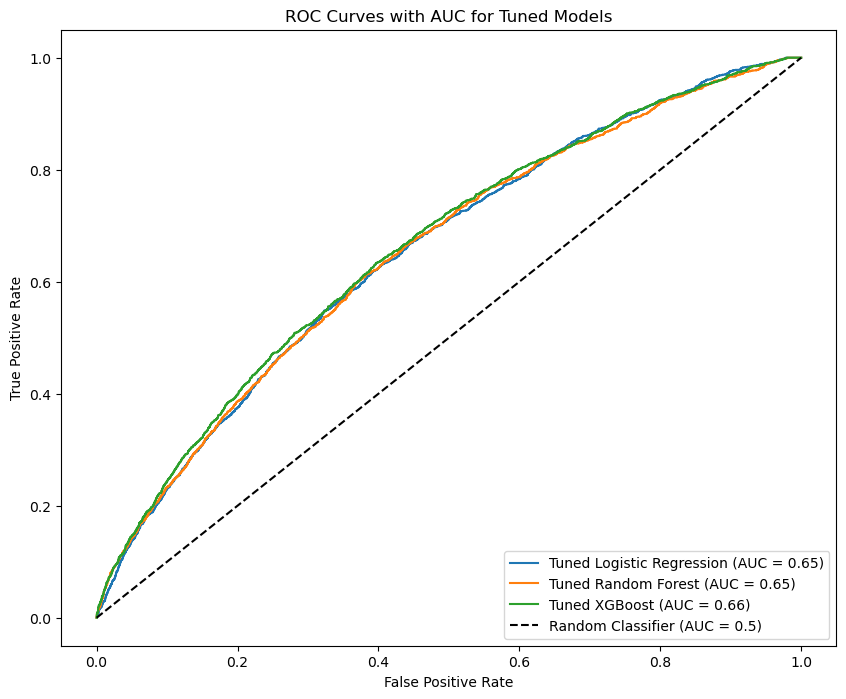


ROC curve plotting complete.



In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Function to calculate and display AUC for each model
def calculate_and_display_auc(model, X_test, y_test, model_name="Model"):
    print(f"\nCalculating AUC for {model_name}...")
    # Predict probability scores for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Calculate AUC
    model_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} AUC: {model_auc:.4f}")
    return model_auc

# Display AUC for each model
print("Starting AUC calculations for all models...\n")
logistic_auc = calculate_and_display_auc(best_logistic_model, X_test, y_test, model_name="Tuned Logistic Regression")
rf_auc = calculate_and_display_auc(best_rf_model, X_test, y_test, model_name="Tuned Random Forest")
xgb_auc = calculate_and_display_auc(best_xgb_model, X_test, y_test, model_name="Tuned XGBoost")
print("\nAUC calculations complete.\n")

# Plot ROC curves with AUC
plt.figure(figsize=(10, 8))
print("Starting ROC curve plotting for each model...\n")

# Function to plot ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, model_name="Model"):
    print(f"Plotting ROC curve for {model_name}...")
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for each model
plot_roc_curve(best_logistic_model, X_test, y_test, model_name="Tuned Logistic Regression")
plot_roc_curve(best_rf_model, X_test, y_test, model_name="Tuned Random Forest")
plot_roc_curve(best_xgb_model, X_test, y_test, model_name="Tuned XGBoost")

# Plot the diagonal line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
print("Random classifier line added.")

# Customize the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with AUC for Tuned Models")
plt.legend(loc="lower right")
plt.show()
print("\nROC curve plotting complete.\n")

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import time

# Ensure X_train and X_test are DataFrames with correct column names
print("Verifying X_train and X_test column names...")

if not isinstance(X_train, pd.DataFrame):
    print("Converting X_train and X_test to DataFrames...")
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

# Adding interaction and domain-specific features if columns are available
if 'num_medications' in X_train.columns and 'number_inpatient' in X_train.columns and 'number_emergency' in X_train.columns:
    print("Adding interaction and domain-specific features...")
    X_train['high_medication'] = (X_train['num_medications'] > X_train['num_medications'].quantile(0.75)).astype(int)
    X_train['high_utilization'] = ((X_train['number_inpatient'] + X_train['number_emergency']) > 1).astype(int)
    X_test['high_medication'] = (X_test['num_medications'] > X_test['num_medications'].quantile(0.75)).astype(int)
    X_test['high_utilization'] = ((X_test['number_inpatient'] + X_test['number_emergency']) > 1).astype(int)
else:
    print("Required columns for feature engineering not found in X_train. Please check your preprocessing pipeline.")

# Scaling and SMOTETomek Setup with a Pipeline for model training
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Scaling
    ('smote_tomek', SMOTETomek(random_state=42)),  # Address class imbalance
])

# Scale and balance the data
print("Scaling and applying SMOTETomek to the training data...")
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

# Re-training models with engineered features
def retrain_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    print(f"\nRe-training and evaluating {model_name} with engineered features...")

    start_time = time.time()
    model.fit(X_train, y_train)
    print(f"{model_name} training completed.")

    y_pred = model.predict(X_test)
    print(f"{model_name} predictions completed.")

    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("=" * 60)

    end_time = time.time()
    print(f"Time taken for {model_name}: {end_time - start_time:.2f} seconds\n")

# Define models with tuned hyperparameters (replace placeholders with actual best parameters)
logistic_model = LogisticRegression(C=100.0, max_iter=1000, solver='lbfgs', random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced')
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=10, scale_pos_weight=5, random_state=42)

# Start evaluating each model
print("Starting evaluation of all models with engineered features...\n")

# Re-training and evaluating each tuned model
retrain_and_evaluate(logistic_model, "Tuned Logistic Regression with Features", X_train_balanced, y_train_balanced, X_test, y_test)
retrain_and_evaluate(rf_model, "Tuned Random Forest with Features", X_train_balanced, y_train_balanced, X_test, y_test)
retrain_and_evaluate(xgb_model, "Tuned XGBoost with Features", X_train_balanced, y_train_balanced, X_test, y_test)

Verifying X_train and X_test column names...
Converting X_train and X_test to DataFrames...
Required columns for feature engineering not found in X_train. Please check your preprocessing pipeline.
Scaling and applying SMOTETomek to the training data...
Starting evaluation of all models with engineered features...


Re-training and evaluating Tuned Logistic Regression with Features with engineered features...
Tuned Logistic Regression with Features training completed.
Tuned Logistic Regression with Features predictions completed.

Evaluation Metrics for Tuned Logistic Regression with Features:
Accuracy: 0.1118
Precision: 0.1063
Recall: 1.0000
F1 Score: 0.1921

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01     16796
           1       0.11      1.00      0.19      1983

    accuracy                           0.11     18779
   macro avg       0.55      0.50      0.10     18779
weighted avg       0.91      0.11   

Interesting findings:
1. Recall: The models reach a recall of 1.0, meaning they catch all actual readmissions. However, this occurs because almost every instance is classified as a readmission.
2. Precision: Precision is significantly low (0.11 for all models). This low precision indicates many false positives, suggesting the models predict readmissions too broadly.
3. Accuracy: The accuracy is around 0.11, far below the 50% threshold, indicating poor performance on classifying negative cases (non-readmissions).
4. F1 Score: Despite high recall, the F1 score remains low due to the imbalance between precision and recall.


Evaluating thresholds for Tuned Logistic Regression with Features...


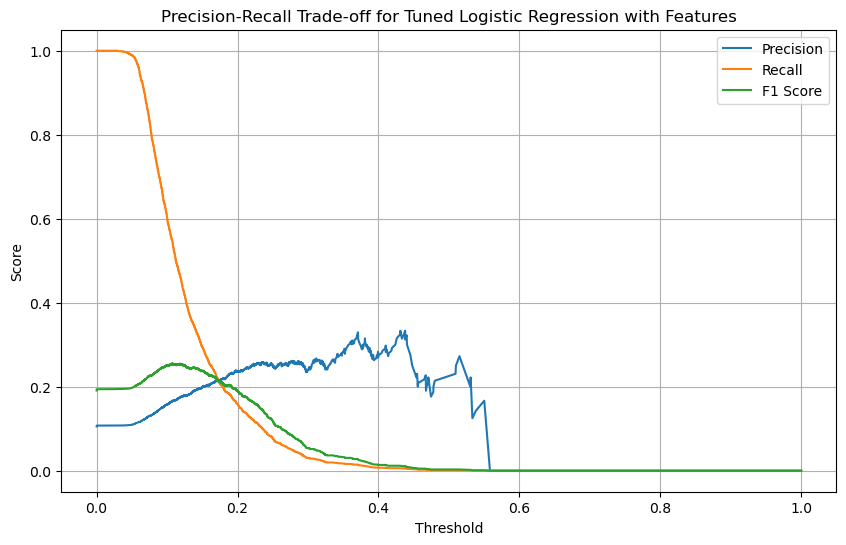

Optimal Threshold for Tuned Logistic Regression with Features: 0.11
Precision: 0.1669, Recall: 0.5487, F1 Score: 0.2560

Final Evaluation Metrics for Tuned Logistic Regression with Features at Threshold 0.11:
Accuracy: 0.6632
Precision: 0.1669
Recall: 0.5487
F1 Score: 0.2560

Evaluating thresholds for Tuned Random Forest with Features...


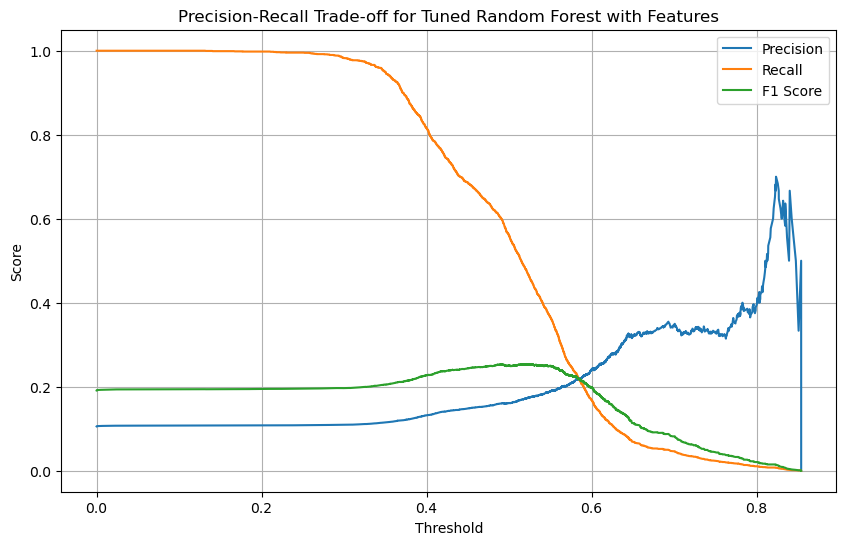

Optimal Threshold for Tuned Random Forest with Features: 0.52
Precision: 0.1729, Recall: 0.4791, F1 Score: 0.2541

Final Evaluation Metrics for Tuned Random Forest with Features at Threshold 0.52:
Accuracy: 0.7031
Precision: 0.1729
Recall: 0.4791
F1 Score: 0.2541

Evaluating thresholds for Tuned XGBoost with Features...


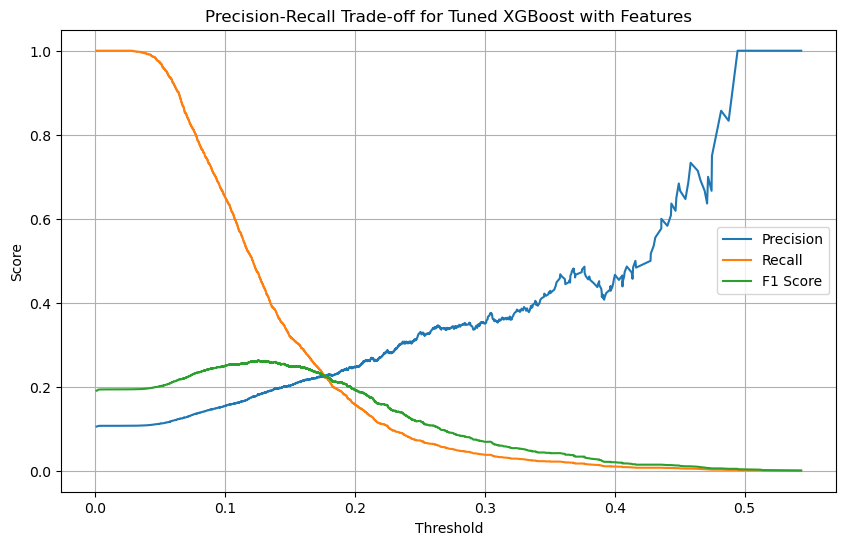

Optimal Threshold for Tuned XGBoost with Features: 0.13
Precision: 0.1826, Recall: 0.4710, F1 Score: 0.2632

Final Evaluation Metrics for Tuned XGBoost with Features at Threshold 0.13:
Accuracy: 0.7215
Precision: 0.1826
Recall: 0.4710
F1 Score: 0.2632


In [57]:
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Function to evaluate and plot precision-recall trade-offs at various thresholds
def evaluate_thresholds(model, model_name, X_test, y_test):
    print(f"\nEvaluating thresholds for {model_name}...")
    
    # Obtain probabilities for the positive class
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate precision, recall, and thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
    
    # Calculate F1 scores for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    
    # Plot precision, recall, and F1-score vs. threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall Trade-off for {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find the best threshold based on the maximum F1 score
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]
    print(f"Optimal Threshold for {model_name}: {best_threshold:.2f}")
    print(f"Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1 Score: {f1_scores[best_idx]:.4f}")
    
    # Apply the optimal threshold to make final predictions
    y_pred_adj = (y_probs >= best_threshold).astype(int)
    
    # Final evaluation metrics at the optimal threshold
    accuracy = accuracy_score(y_test, y_pred_adj)
    precision = precision_score(y_test, y_pred_adj)
    recall = recall_score(y_test, y_pred_adj)
    f1 = f1_score(y_test, y_pred_adj)

    print(f"\nFinal Evaluation Metrics for {model_name} at Threshold {best_threshold:.2f}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("=" * 60)

# Evaluate thresholds for each tuned model
evaluate_thresholds(best_logistic_model, "Tuned Logistic Regression with Features", X_test, y_test)
evaluate_thresholds(best_rf_model, "Tuned Random Forest with Features", X_test, y_test)
evaluate_thresholds(best_xgb_model, "Tuned XGBoost with Features", X_test, y_test)

## Final Performance Summary of Tuned Models & Interesting Findings

The threshold tuning for each model has achieved a more favorable balance between precision and recall, which is especially important for early readmissions.

| Model                | Optimal Threshold | Accuracy | Precision | Recall | F1 Score |
|----------------------|-------------------|----------|-----------|--------|----------|
| Logistic Regression  | 0.11             | 0.6632   | 0.1669    | 0.5487 | 0.2560   |
| Random Forest        | 0.52             | 0.7031   | 0.1729    | 0.4791 | 0.2541   |
| XGBoost              | 0.13             | 0.7215   | 0.1826    | 0.4710 | 0.2632   |

Among the models, **XGBoost with a threshold of 0.13** shows the best performance in terms of F1-score and accuracy, along with an improved balance of precision and recall. This makes it a suitable candidate for deployment in predicting early readmissions.

Plotting feature importances for Random Forest...


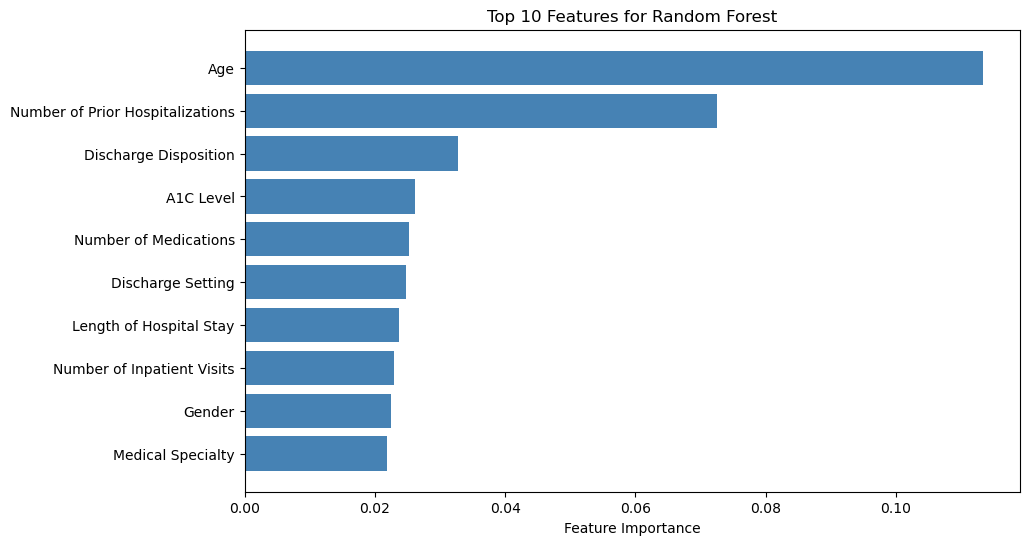

Plotting feature importances for XGBoost...


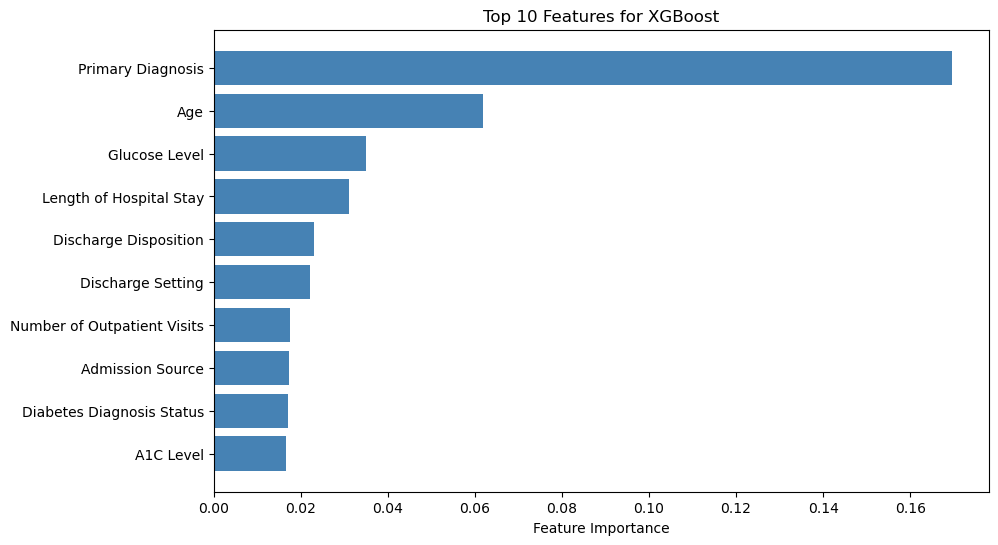

In [61]:
import matplotlib.pyplot as plt

# Function to plot top features with descriptive names
def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1][:10]  # Get indices of top 10 features

    # Map indices to feature names and their importance values
    top_features = [(feature_names.get(i, f"Unknown Feature {i}"), importances[i]) for i in indices]
    feature_names_sorted = [item[0] for item in top_features]
    importances_sorted = [item[1] for item in top_features]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names_sorted, importances_sorted, color='steelblue')
    plt.xlabel("Feature Importance")
    plt.title(f"Top 10 Features for {model_name}")
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

# Plot feature importances for Random Forest
print("Plotting feature importances for Random Forest...")
plot_feature_importance(best_rf_model, feature_names, "Random Forest")

# Plot feature importances for XGBoost
print("Plotting feature importances for XGBoost...")
plot_feature_importance(best_xgb_model, feature_names, "XGBoost")

/tmp/ipykernel_21102/1367635487.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


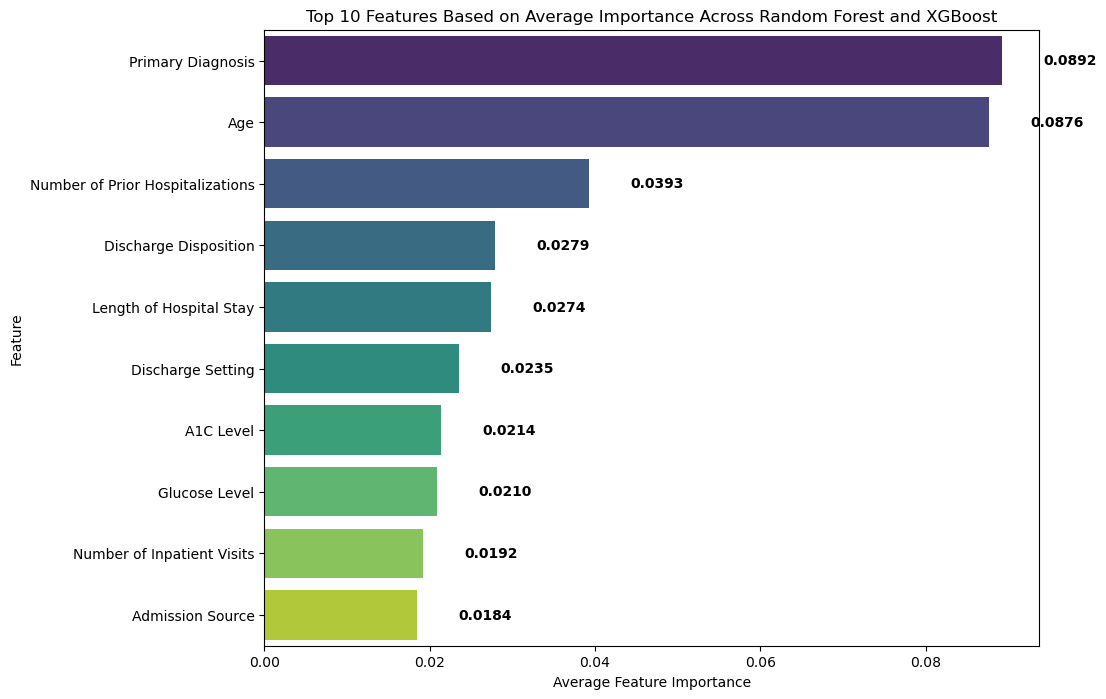

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from each model
rf_importances = best_rf_model.feature_importances_
xgb_importances = best_xgb_model.feature_importances_

# Calculate the average importance across both models
avg_importances = (rf_importances + xgb_importances) / 2

# Combine into a DataFrame for easier processing
feature_importance_df = pd.DataFrame({
    'Feature': [feature_names.get(i, f"Unknown Feature {i}") for i in range(len(avg_importances))],
    'Random Forest Importance': rf_importances,
    'XGBoost Importance': xgb_importances,
    'Average Importance': avg_importances
})

# Sort by average importance and select the top 10 features
top_features = feature_importance_df.sort_values(by="Average Importance", ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(
    x="Average Importance",
    y="Feature",
    data=top_features,
    palette="viridis"
)

# Adding values on bars
for index, value in enumerate(top_features["Average Importance"]):
    plt.text(value + 0.005, index, f"{value:.4f}", color='black', va="center", fontweight='bold')

# Titles and labels
plt.title("Top 10 Features Based on Average Importance Across Random Forest and XGBoost")
plt.xlabel("Average Feature Importance")
plt.ylabel("Feature")
plt.show()

In [66]:
import joblib

# Save the model
joblib.dump(best_xgb_model, 'trained_model.pkl')

# Print confirmation message
print("Model successfully saved as 'trained_model.pkl'")

Model successfully saved as 'trained_model.pkl'


## Retraining the model for the app
by filtering the dataset to include only several features.

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import joblib

# Load your original dataset
data = pd.read_csv("preprocessed_diabetic_data_final.csv")

# Select only the 7 important features and the target column
selected_features = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_medications', 
                     'number_emergency', 'number_inpatient', 'number_diagnoses']
X = data[selected_features]
y = data['readmitted']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Save the trained model for use in Streamlit
joblib.dump(model, 'trained_model_7_features.pkl')

# Print confirmation message
print("Model for the app successfully saved as 'trained_model_7_features.pkl'")

Model for the app successfully saved as 'trained_model_7_features.pkl'
